# Notebook Setup

Markdown comments = thoughts on high-level, project-management-esque decisions

`# Inline or cell-blocked code comments = thoughts on low-level, coding/optimization decisions `

### **Preface**
Given the freedom of this assignment, there was a lot of different branching choices one can make when doing this NLP modeling.

In order to account for these branching choices, I will acknowledge them throughout the notebook with the label `Potential Future Work` and provide some unimplemented "starting" code. This way, I can demonstrate my understanding of a more comprehensive ML/NLP project but also not spend too much time on over-engineering an assignment that is suppose to be a simple, "proof-of-concept" model.

In [1]:
# Imports
import sys
sys.path.append("../modules/")
import imports
import helper
import evaluate

# To see a full list of my imports, functions, and global variables, see ../modules/ folder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [111]:
# # Reload modules
# import importlib
# importlib.reload(evaluate)
# importlib.reload(imports)
# importlib.reload(helper)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<module 'helper' from 'd:\\GitHub\\Github Projects\\daquin-language-evolution\\dev\\../modules\\helper.py'>

In [3]:
# Loading data
filename = "twitter_preprocessed"
filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
df = imports.pd.read_csv(filepath)
df.head()

,Text,Topics,Retweet,URL,Mention,Hashtag,Word Count,Sentiment Score,Cyberbullying,Class,Mapped Class
0,read context change meaning history islamic sl...,NaN,0,1,1,0,7,-0.7003,False,none,1
1,idiot claim people tried stop becoming terrori...,NaN,0,0,1,0,12,-0.9648,False,none,1
2,call sexist go auto place id rather talk guy,NaN,1,0,1,0,9,0.0000,True,sexism,2
3,wrong ISIS follows example mohammed quran exactly,NaN,0,0,1,0,7,-0.4767,True,racism,3
4,NaN,mkr,0,0,0,1,0,0.0000,False,none,1


# Modeling

## Big Idea: Using Random Forests

Going to start with **random forest** (RF) to tackle a multi-class classifier because RF:
- can handle multi-class classification
- handles non-linear relationships well
    - in textual classification, relationship between words and their meanings are often non-linear
- identifies feature importance relatively well
    - given project's overall purpose, having the ability to understand conclusions via feature importance is integral for interpretability
- handles imbalanced classes relatively well (we have imbalacned class dataset)
    - the averaging mechanism in the ensemble helps mitigate the effects of class imbalance, leading to more balanced predictions
    - also fits fine with any class imbalance techniques like SMOTE
- handles overfitting relatively well
    - due to averaging mechanism again, each tree is trained on a subset of the data and features, reducing the risk of memorizing noise in the data
    - overall, it's ideal for high-dimensional NLP tasks

### `Potential Future Work: Other Models`

Perhaps the most immediate branching decision at this point would be the choice of models. There are several other model considerations, like logistic regression or deep learning neutral networks. A logistic regression is particularly strong and cost-effective (more cost-effective than Random Forests) at **binary** classifications, but I ultimately went against it because I wanted to pursue the multi-class classification approach. Likewise, a neural network would be the most comprehensive, but it suffers heavily from compute costs and interpretability (black-box model), which is perhaps not as useful considering the regulatory context of this project.

However, in future extended work, we could implement multiple models and compare their performance. I will preprocess the data to make it compatible with said hypothetical future models to allow for seamless integration into a larger project. 

In [4]:
# # Creating df to store all the model scores
# index_name = "dummy_model"
# tracked_metrics = ["precision", "recall", "f1-score", "accuracy", "auc"] 
# all_scores = imports.pd.DataFrame(columns=tracked_metrics, 
#                                   data=[imports.np.zeros(len(tracked_metrics))], 
#                                   index=[index_name])
# # we need a dummy row for this df due a pandas warning; in future it won't allow concat w empty dfs or dfs w only nans

## General Data Setup

In [5]:
# Defining variables for in/dependent variables
drop_cols = ["Text", "Topics", "Cyberbullying", "Class", "Mapped Class"] # removing irrelevant columns
dep_col = "Mapped Class"
pos_class_name_1 = "Not Cyberbullying"
neg_class_name_2 = "Sexism"
neg_class_name_3 = "Racism"
class_names = [pos_class_name_1, neg_class_name_2, neg_class_name_3]

# Defining ratios
train_ratio = imports.DEFAULT_TRAIN
validation_ratio = imports.DEFAULT_VAL
test_ratio = imports.DEFAULT_TEST

## Text Vectorization: TFIDF

In [6]:
# Preparing the data for preprocessing
X_partial = df.drop(drop_cols, axis=1)
X_text = df["Text"].fillna("")
X_topic = df["Topics"].fillna("")
X_corpus = imports.pd.concat([df["Text"], df["Topics"]], axis=0).dropna()
y = df[dep_col]

In [7]:
# Fitting vectorizers on corpuses
tfidf_vectorizer = imports.TfidfVectorizer()
tfidf_vectorizer.fit(X_corpus)

# Vectorizing text and topics
X_text_tfidf_vectorized = tfidf_vectorizer.transform(X_text)
X_topic_tfidf_vectorized = tfidf_vectorizer.transform(X_topic)

# Combining vectorization into overall df
tfidf_text = imports.pd.DataFrame(X_text_tfidf_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_text.reset_index(drop=True, inplace=True)
tfidf_topic = imports.pd.DataFrame(X_topic_tfidf_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_topic.reset_index(drop=True, inplace=True)
X = imports.pd.concat([X_partial, tfidf_text, tfidf_topic], axis=1)
X = X.loc[:, ~X.columns.duplicated()] # drop duplicates

# Viewing X
X.head()

,Retweet,URL,Mention,Hashtag,Word Count,Sentiment Score,00,000,01,02,...,zozo,zucchini,zuckerberg,zuppa,zynga,zzzz,الرصافة,ايلي,ايليا,غنى_قلبي
0,0,1,1,0,7,-0.7003,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,12,-0.9648,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,9,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,0,7,-0.4767,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Saving final training data (X)
filename = "twitter_final_preprocessed_tfidf"
filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
X.to_csv(filepath, index=False)

# Loading final training data
# filename = "twitter_final_preprocessed_tfidf"
# filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
# X = imports.pd.read_csv(filepath)

### `Potential Future Work: Other Vectorizers`

One idea is to implement different vectorization algorithms for more robust higher comparisons. TFIDF is a bag-of-words type of approach to vectorization (aka classifying statements based on the mere presence of certain keywords) that is simple and compute-efficient. However, we can also vectorize the data with the Word2Vec algorithm, which while more computationally costly, would enable meaning-laden interpretations (aka classifying phrases based on their relative semantic meaning to other phrases in the corpus).

We could then take multiple variants of the training data (variants because they have been vectorized differently) and pass them into our models. This would add another layer of robustness and predictive power, but it also adds another layer of complexity.

In [9]:
# w2v_vectorizer = imports.Word2Vec(X_corpus, min_count=1)

# def word2vec_vectorize(words, model, vector_size):
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     if not word_vectors:
#         return np.zeros((1, model.vector_size))
#     return np.mean(word_vectors, axis=0).reshape(1, -1)
# X_text_word2vec_vectorized = X_text.apply(lambda x: word2vec_vectorize(x, w2v_vectorizer, vector_size=100))
# X_topic_word2vec_vectorized = X_topic.apply(lambda x: word2vec_vectorize(x, w2v_vectorizer, vector_size=100))

# # Combine with partial
# X_word2vec = imports.pd.concat([X_partial, X_text_word2vec_vectorized, X_topic_word2vec_vectorized], axis=1)
# X_word2vec = X_word2vec[list(X_word2vec.columns)[-2:] + list(X_word2vec.columns)[:-2]] 

## Data Transformation

Prior to training, I want to some final touch-ups to the dataset to make it "model-agnostic", or compatible with any future modeling efforts.
- Standard scaling
- SMOTE
- Train-val-test split

I will pursue standard scaling to normalize the data for all models (e.g. random forest is not affected by scale, but other models are.)

Then, I will utilize SMOTE to take care of the class imbalance found in the EDA.
- none      68%
- sexism    20%
- racism    12%

Next, I will use train-val-test split to organize my training data. Specifically, I will train the model on the training data and evaluate it on the validation data. This evaluation on the validation data refers to the "testing on withheld data" requirement on the assignment. 

The testing data split is reserved for imagined future work as mentioned above. For example, if future work consisted of training multiple models and then comparing their results, we would compare the models on validation data, and take the highest performer, and then test that highest performer on the testing data.

In [10]:
# Columns that need different preprocessing
numerical_features = ["Word Count", "Sentiment Score"]
categorical_features = [col for col in X.columns if col not in numerical_features]

In [11]:
# Setup preprocessor
transformers = [("num", imports.StandardScaler(), numerical_features),
                ("cat", "passthrough", categorical_features)] # do nothing to cat features
preprocessor = imports.ColumnTransformer(transformers)

# Scale data
fitted_preprocessor = preprocessor.fit(X)
X_scaled = fitted_preprocessor.transform(X)

# Save the fitted preprocessor
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/preprocessor.pkl"
imports.joblib.dump(fitted_preprocessor, filepath)

['../outputs/saved_models/preprocessor.pkl']

In [18]:
# Apply SMOTE to take care of class imbalance
smote = imports.SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [19]:
# Split data -> train/test
X_train, X_test, y_train, y_test = imports.train_test_split(X_resampled, y_resampled, 
                                                            test_size=(1 - train_ratio), 
                                                            random_state=imports.RANDOM_SEED)
# Split test -> test/val
X_val, X_test, y_val, y_test = imports.train_test_split(X_test, y_test, 
                                                        test_size=test_ratio/(test_ratio + validation_ratio), 
                                                        random_state=imports.RANDOM_SEED)

Below is optional code to extract/save the parsed training, validation, and testing data.

In [20]:
# Saving the data
# zip1 = [X_train, X_val, X_test]
# zip2 = [y_train, y_val, y_test]
# names = ["training", "validation", "testing"]

# for i in range(len(zip1)):
#     ready_df = imports.pd.concat([zip1[i], zip2[i]], axis=1)
#     filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/twitter_{names[i]}_dataset.csv"
#     ready_df.to_csv(filepath, index=False)

## Training

In [21]:
# Initialize the model
model_name = "Random Forest TFIDF" # model name used for saving files/differentiating graphs
model = imports.RandomForestClassifier(n_estimators=50, random_state=imports.RANDOM_SEED)

In [22]:
# Fitting the model
model.fit(X_train, y_train)

# Use model on predictions
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)

In [23]:
# Save the model
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/trained_non_gs_{model_name.replace(" ", "_").lower()}.pkl"
imports.joblib.dump(model, filepath)

['../outputs/saved_models/trained_non_gs_random_forest_tfidf.pkl']

In [24]:
# # Load the best model
# filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/trained_random_forest_tfidf.pkl"
# best_model = imports.joblib.load(filepath)

### `Potential Future Work: Hyperparameter Tuning`

With more compute power and time, another thing to do is hyperparameter tuning via a GridSearch and overfitting testing with cross-validation.

The code below creates a pipeline for such a process.

In [25]:
# # Initialize the model
# model_name = "Random Forest TFIDF" # model name used for saving files/differentiating graphs
# model = imports.RandomForestClassifier(n_estimators=100, random_state=imports.RANDOM_SEED)
# optimizer_score = "roc_auc_ovr"
# folds = imports.DEFAULT_FOLDS

# # Create param grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Creating the grid_search "model"
# grid_search = imports.GridSearchCV(estimator=model,
#                                    param_grid=param_grid, 
#                                    cv=folds, 
#                                    scoring=optimizer_score,
#                                    verbose=1)

# # Fitting the model with the best parameters
# grid_search.fit(X_train, y_train)

# # Best parameters
# print(f"Best Parameters: {grid_search.best_params_}")

# # Use best model from grid search for predictions
# y_pred = best_model.predict(X_val)
# y_pred_prob = best_model.predict_proba(X_val)

# # Save the best model
# best_model = grid_search.best_estimator_
# filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/trained_{model_name.replace(" ", "_").lower()}.pkl"
# imports.joblib.dump(best_model, filepath)

## Evaluation (on Validation)

### Feature Importance

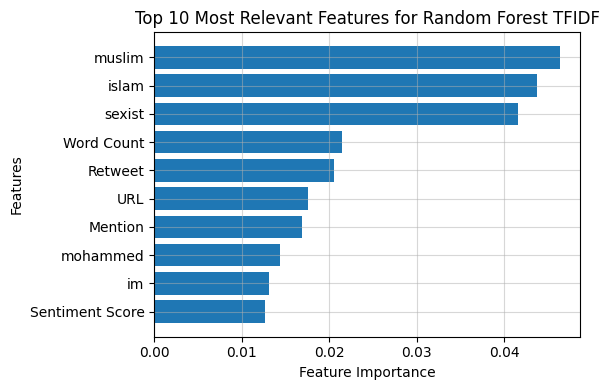

In [26]:
# Custom function wrote in evaluate module for ease of refactoring/scaling pipeline to more models
evaluate.graph_feature_importance(model_name, model, X.columns, 10)

The above shows the relative importance of each feature (either a token or category) **overall**. From prior formatting, features that are in lowercase refer to tokens or specific words, while features with titlecase refer to categories (e.g. "Retweet" = "Was this text input a retweet", "Word Count" = "the scaled value of the word count for the text input".) 

- For instance, `muslim` is the (relatively) strongest indicator for the model when deciding if an input text is class 1, 2, or 3 (not cyberbullying, sexist, or racist).
- Likewise, `Retweet` means that the whether a phrase was a retweet or not was a strong deciding factor for whether it was or was not cyberbullying.
- And lastly, `Word Count` also means that the amount of meaning-laden tokens in an input text was a strong deciding factor. (For example, text inputs that have a lot of "fluff" words typically have lots of noise and not are not strong predictors for whether something was or was not cyberbullying.

### `Potential Future Work: Class-by-Class Feature Investigation`

While random forests have built-in functionality for revealing feature importance, it doesn't natively provide a breakdown of feature importance by class (mathematically, it's calculated based on how much each feature decreases the impurity across *all* trees, not trees of specific classes). Two ways to do this is to retrain the model three separate times, permutating through the combinations of classes so that it's a binary classifier, or to use SHAP Values to derive feature importance.

In [27]:
# # Extracting feature importance on a class-by-class basis

# # Get class-by-class dataset
# for i in range(1, 4):
#     filtered_indexes = y_train[y_train == i].index.tolist() # Fetch class labels
#     filtered_training_df = X_train.loc[filtered_indexes] # Filter training_data by class labels
#     predicted_class = best_model.predict(filtered_training_df) # Predict using class-specific dataset
#     evaluate.graph_feature_importance(f"Class {i}", best_model, filtered_training_df.columns, 10)

### Confusion Matrix

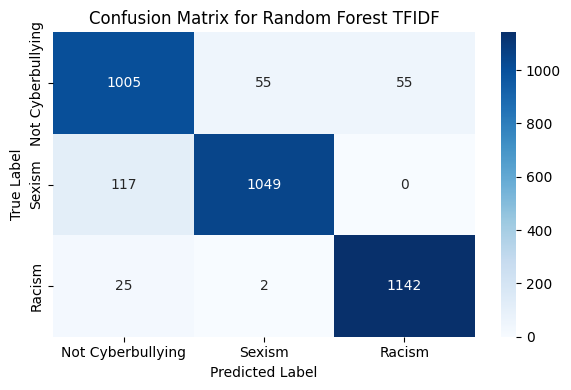

In [28]:
cm = evaluate.graph_confusion_matrix(y_val, y_pred, class_names, model_name)

Overall, the model seems to be very strong at predicting true positives (the diagonal blue line).

- There are 110 cases (3.1% of all cases) of false positives or Type I errors--where we erronously label "bad" cases as "good".
- There are 144 cases (4.2% of all cases) of false negatives or Type II errors--where we erronously label "good" cases as "bad".

In terms of errors, this means that the model slightly leans towards make false negative predictions (or specifically, the mode is slightly more likely to accidentally predict a non-cyberbullying case as sexist or racist than it is to predict a sexist or racist case as non-cyberbullying).

Future work such as experimenting with the vectorization algorithms might be influential in pushing down the rate of errors (e.g. Word2Vec)

### Classification Report

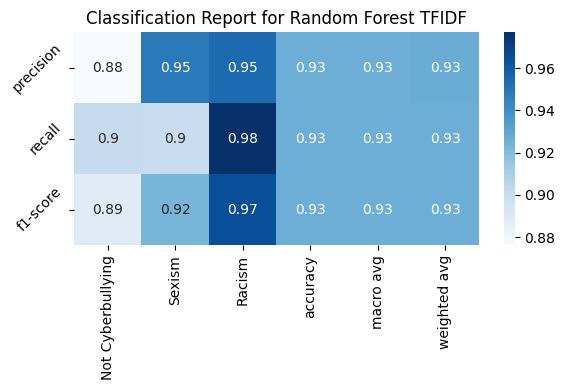

In [29]:
class_df = evaluate.graph_classification_report(y_val, y_pred, class_names, model_name)

As seen above, our class 1 ("not cyberbullying) has the weakest scores among the other two classes, which is corroborated with our confusion matrix. Likewise, on the flip end, the racism class scores very in all metrics.

A high precision score reflects fewer false positives, while a higher recall reflects fewer false negatives. The F1-score, being the harmonic mean, is a good balanced summary of how well each class scored, and even at the model's weakest F1 score, the "not cyberbullying" class scored a 0.89.

Interpreting one of the scores as an example, a precision score of 0.95 for racism means that when a model guesses something to be the class "racism", it is correct 95% of the time. Due to SMOTE, a naive guesser would guess this 33% of the time. 

Likewise, accuracy is also a decent metric here, as it shows that 93% of the time across all classes, the model guesses the correct answer. (A naive guesser would guess the correct tag only 33% of the time.)

This shows that the RF model scores significantly better than a baseline guess.

### ROC Curve

To create an ROC Curve, I will use the one-vs-rest strategt.

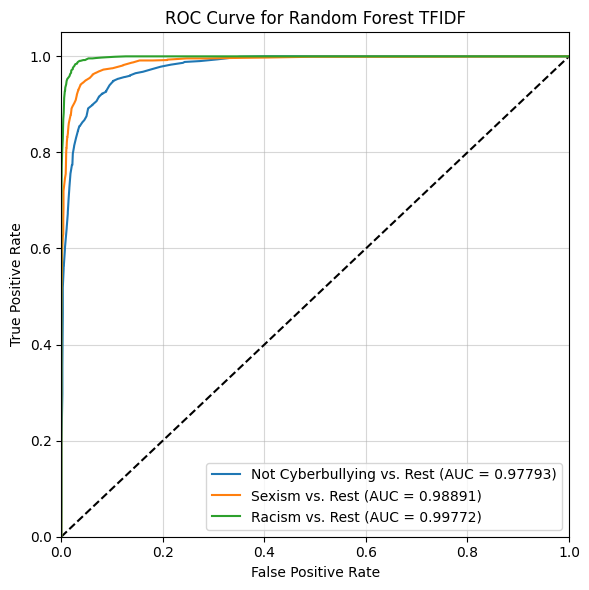

In [112]:
roc_multi = evaluate.graph_multi_roc(class_names, model, y_val, y_pred_prob, model_name)

When comparing the ROC curves on the OvR, we see that the model has strong performance in separating/differentiating between the different classes, with the strongest performance on the racism class.

For example, when differentiating between "not cyberbullying" vs. any other class, our model can predict this 97.8% of the time, while a naieve guesser would only predict this 50% of the time. This suggests that the model is a strong performance improvement.

## Evaluation (on Testing)

We can also evaluate the validation vs. testing data in future work in which we compare different models.

In [113]:
# # Getting predictions on testing value
# y_test_pred = model.predict(X_test)
# y_test_pred_prob = model.predict_proba(X_test)

# # Compiling test results
# model_name_test = "Random Forest TFIDF Testing"
# class_test_df = evaluate.graph_classification_report(y_test, y_test_pred, class_names, model_name_test)
# roc_multi_test = evaluate.graph_multi_roc(class_names, model, y_test_pred, y_test_pred_prob, model_name_test)

# # Vars
# target_metric = "f1-score"
# cutoff = 3

# # Extracting Validation
# new_names_classification = [f"{name} {target_metric.title()}" for name in class_df.index[:cutoff].tolist()]
# new_names_auc = [f"{name} AUC" for name in class_df.index[:cutoff].tolist()]
# new_names = new_names_classification + new_names_auc
# target_values_classification = class_df[target_metric][:cutoff].tolist()
# target_values_auc = list(roc_multi.values())
# target_values_val = target_values_classification + target_values_auc

# # Extracting Testing
# target_values_classification = class_test_df[target_metric][:cutoff].tolist()
# target_values_auc = list(roc_multi_test.values())
# target_values_test = target_values_classification + target_values_auc

# compare_df = imports.pd.DataFrame([target_values_val, target_values_test], columns=new_names, index=["Validation", "Testing"])
# compare_df

# title = "RF TFIDF Val-Test Comparisons"
# xlabel = "Metrics"
# ylabel = "Values"
# evaluate.graph_bar_comparison(compare_df, title, xlabel, ylabel)